In [1]:
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser
import math
import seaborn as sns

In [2]:
fc = FileChooser('./')
fc.title = "<b>Select preprocessing parameter file</b>"
fc.filter_pattern = ['*.npz']
display(fc)

FileChooser(path='C:\Users\omgui\Desktop\BASUS', filename='', title='<b>Select preprocessing parameter file</b…

In [4]:
data = np.load(fc.selected, allow_pickle=True)
amplitudes = data['handlesA'].item()['amplitude']
normalized_amplitudes = amplitudes / np.max(amplitudes)
hist, bin_edges = np.histogram(normalized_amplitudes, bins=100, range=(0, 2), density=True)

In [ ]:
NA = 1
lam1 = 5.6e-7
zRscale = 3
w0 = lam1/(2*NA)
zR = zRscale*(math.pi*(w0**2)/lam1)
def generate_psf_from_GLbeam(w0=w0, zR=zR, yfactor=2.5, zfactor=3.5, beam_index=2.1, bins=100):
    y = np.linspace(-yfactor * w0, yfactor * w0, 500)
    z = np.linspace(-zfactor * zR, zfactor * zR, 500)
    Z, Y = np.meshgrid(z, y)

    # Gaussian-Lorentzian Beam (GLbeam)
    wlor2 = (w0**2) * (1 + (Z / zR)**2)
    BGL = (w0**2 / wlor2) * np.exp(-2 * (Y**2 / wlor2))

    B = np.power(BGL / np.max(BGL), beam_index)

    psf, _ = np.histogram(B.flatten(), bins=bins, range=(0, 2), density=True)
    psf = psf / np.sum(psf)
    return psf

psf = generate_psf_from_GLbeam()

In [ ]:
def richardson_lucy(measured, psf, iterations=50):
    psf_mirror = psf[::-1]
    estimate = measured.copy()
    estimate[estimate < 1e-10] = 1e-10 

    for _ in range(iterations):
        conv_result = convolve(estimate, psf, mode='same')

        relative_blur = measured / conv_result
        estimate *= convolve(relative_blur, psf_mirror, mode='same')
    
    return estimate

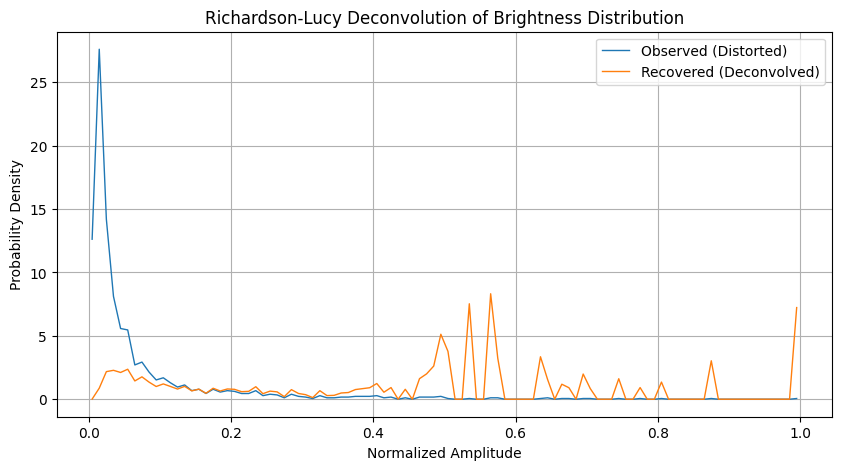

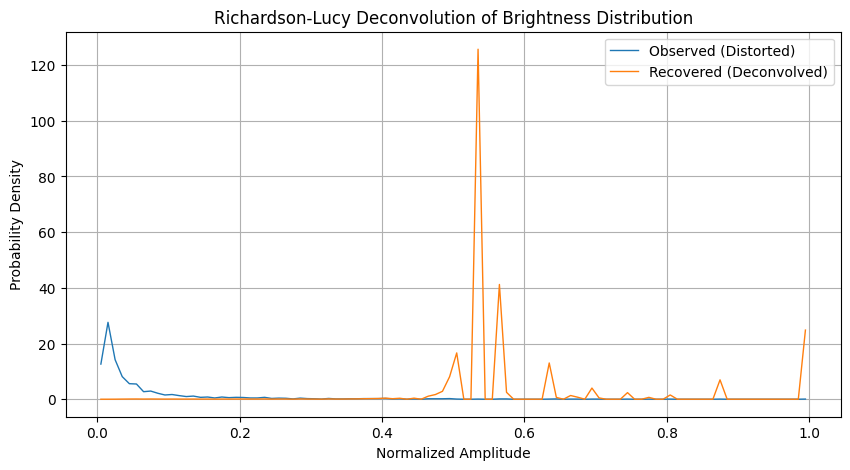

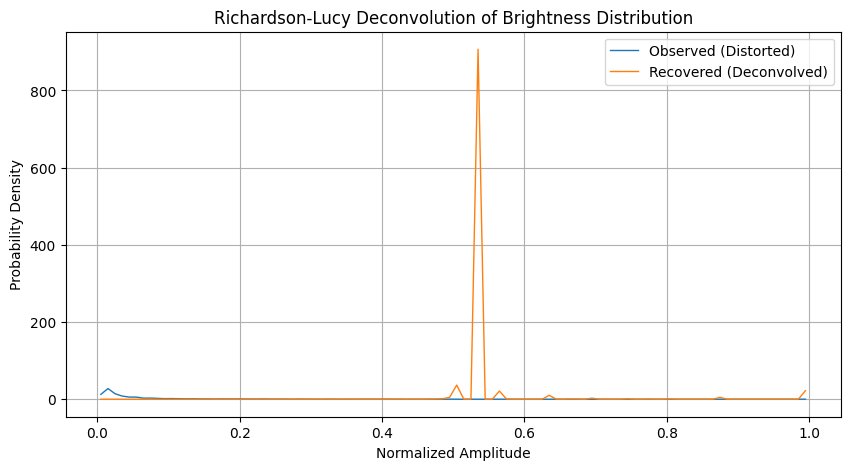

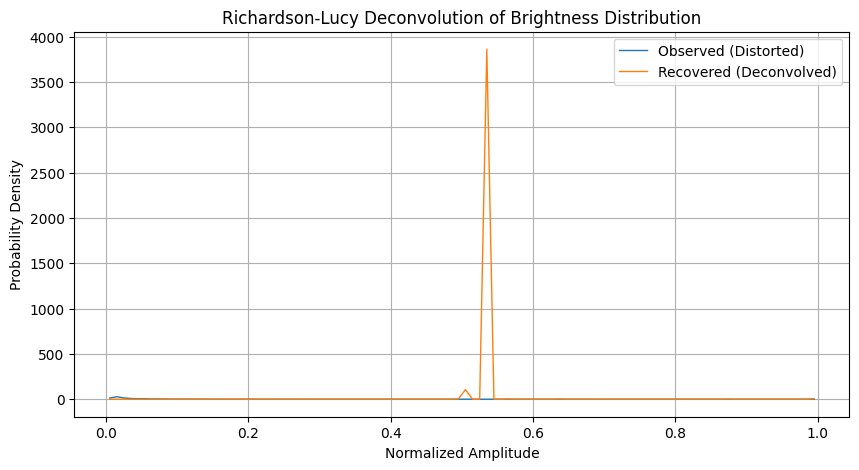

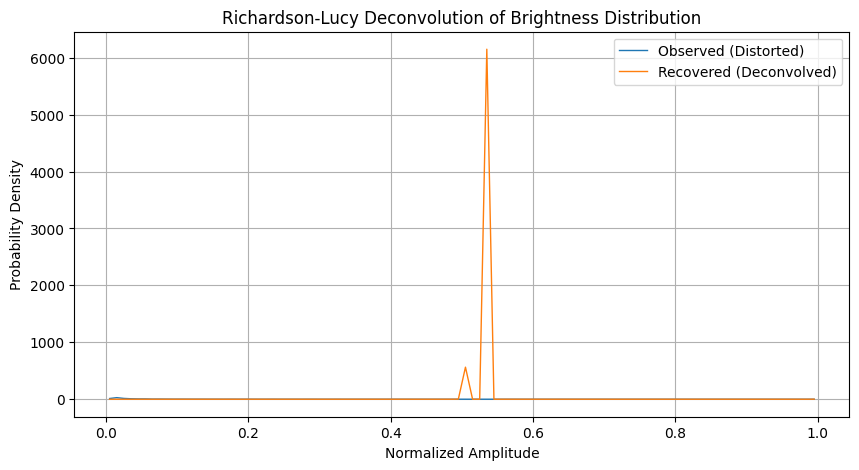

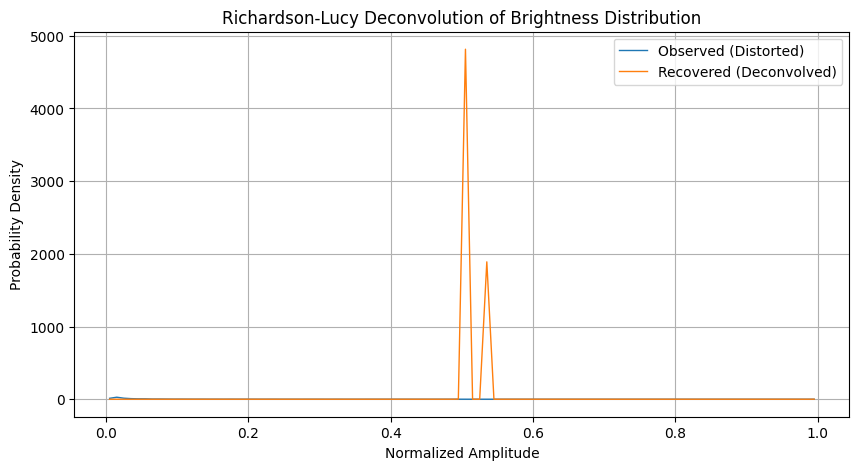

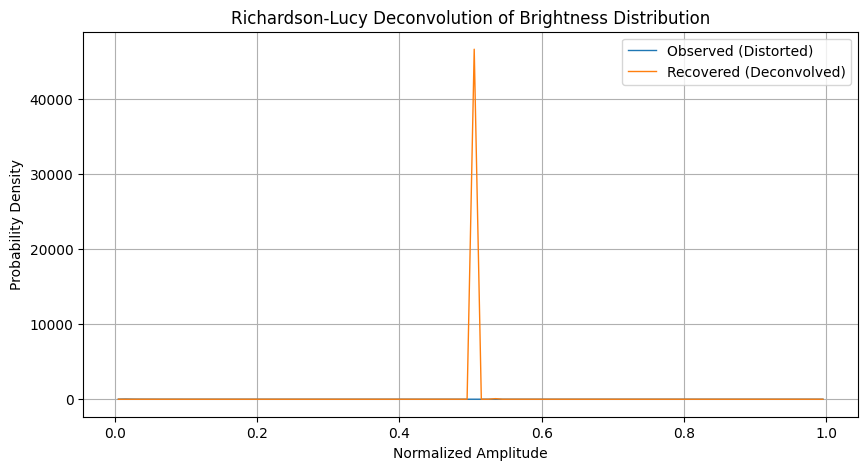

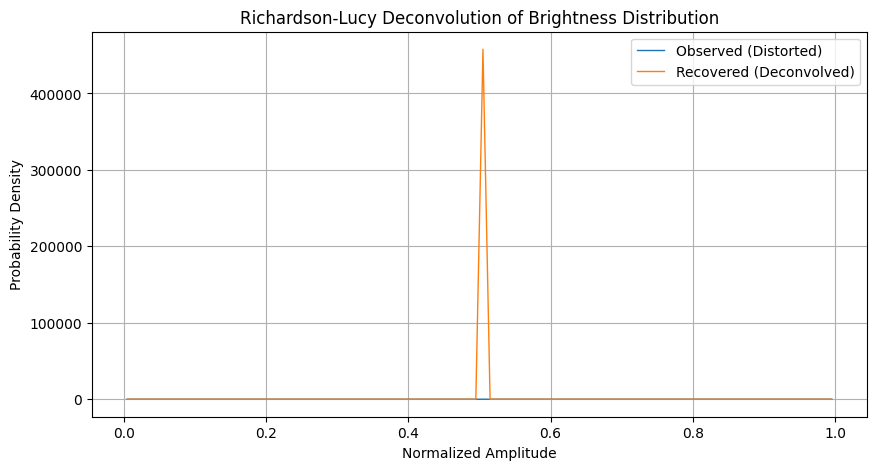

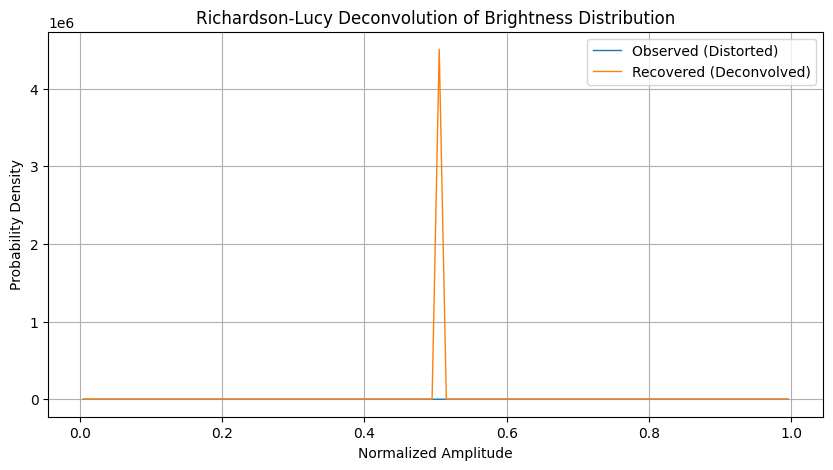

In [94]:
for i in range(1, 10):
    recovered = richardson_lucy(hist, psf, iterations = i)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.figure(figsize=(10,5))
    plt.plot(bin_centers, hist, label="Observed (Distorted)", lw=1)
    plt.plot(bin_centers, recovered, label="Recovered (Deconvolved)", lw=1)
    plt.xlabel("Normalized Amplitude")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.title("Richardson-Lucy Deconvolution of Brightness Distribution")
    plt.grid(True)
    plt.show()

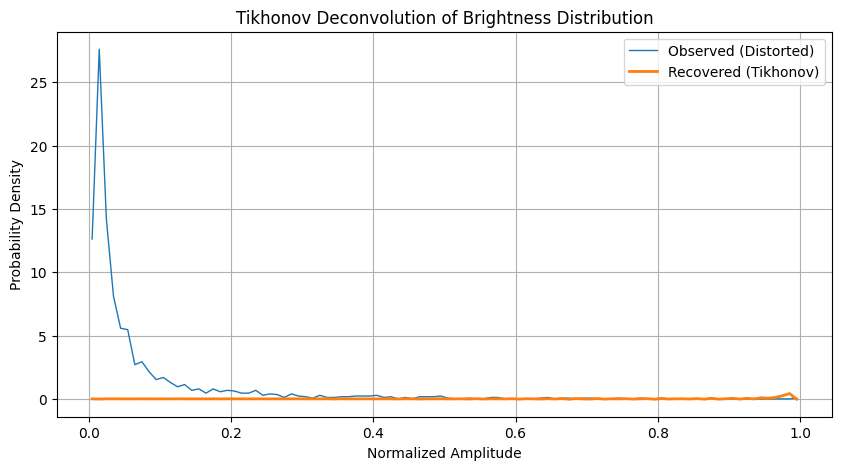

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.signal import convolve

# Load and normalize data
data = np.load(fc.selected, allow_pickle=True)
amplitudes = data['handlesA'].item()['amplitude']
normalized_amplitudes = amplitudes / np.max(amplitudes)

# Histogram observed data
bins = 100
hist, bin_edges = np.histogram(normalized_amplitudes, bins=bins, range=(0, 1), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
b = hist

# Generate PSF histogram
def generate_psf_from_GLbeam(w0, zR, yfactor=2.5, zfactor=3.5, beam_index=2.1, bins=100):
    y = np.linspace(-yfactor * w0, yfactor * w0, 500)
    z = np.linspace(-zfactor * zR, zfactor * zR, 500)
    Z, Y = np.meshgrid(z, y)

    wlor2 = (w0**2) * (1 + (Z / zR)**2)
    BGL = (w0**2 / wlor2) * np.exp(-2 * (Y**2 / wlor2))
    B = np.power(BGL / np.max(BGL), beam_index)

    psf, _ = np.histogram(B.flatten(), bins=bins, range=(0, 1), density=True)
    psf = psf / np.sum(psf)
    return psf

# Optical parameters
NA = 1
lam1 = 5.6e-7
zRscale = 3
w0 = lam1 / (2 * NA)
zR = zRscale * (np.pi * w0**2 / lam1)

psf = generate_psf_from_GLbeam(w0=w0, zR=zR, bins=bins)

# Build convolution matrix A from PSF (Toeplitz structure)
first_col = np.zeros(bins)
first_col[0:len(psf)] = psf[::-1]
first_row = np.zeros(bins)
first_row[0] = psf[-1]
A = toeplitz(first_col, first_row)

# Regularization matrix (L = identity for 0th-order Tikhonov)
L = np.eye(bins)

# Regularization strength (adjust if oversmoothing or undersmoothing)
λ = 1e-10  # You can tune this: try 1e-3, 1e-1, 1

# Solve (AᵀA + λLᵀL)x = Aᵀb
ATA = A.T @ A
ATb = A.T @ b
reg_term = λ * (L.T @ L)
x = np.linalg.solve(ATA + reg_term, ATb)

# Normalize result
x /= np.sum(x)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(bin_centers, b, label="Observed (Distorted)", lw=1)
plt.plot(bin_centers, x, label="Recovered (Tikhonov)", lw=2)
plt.xlabel("Normalized Amplitude")
plt.ylabel("Probability Density")
plt.title("Tikhonov Deconvolution of Brightness Distribution")
plt.legend()
plt.grid(True)
plt.show()
